## Model selection

In this script JAGS output for HLM sequential model containing four competing submodels is analyzed. Specifically posterior samples for model indicator variable $z_i$ are used to perform model selection. Model selection can be quantified with Bayes factors and protected exceedance probabilities.

### Bayes factor

Model indicator variable $z_i$ can be used to discriminate between prediction-error independent (PI) and prediction-error dependent (PD) models. This approach called transdimensional MCMC encompasses both reversible jump MCMC and the product space technique (Sission, 2005). Bayes factors for PI vs PD model selection can be directly calculated for each participant as a ratio of model indicator samples. Bayes factor is the standard Bayesian solution to the model selection problems (Lewis & Raftery, 1997). Bayes factor (BF) for two models $M_1$ and $M_2$ is defined as:
$$BF_{12}=\frac{p(D|M_1)}{p(D|M_2)}$$

---
**Last update**: 10.06.2020 

In [1]:
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import scipy.io
import os

from collections import Counter

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)

In [2]:
def gen_pep_barplot(pep, model_names, outpath=None):
    """Create protected exceedance probability barplot.

    Args:
        pep: 
            protected exceedance probabilities for any number of models
        modelname: 
            list of modelnames
        outpath (optional):
            path specification for saving figure
    """
    n_models = len(pep)

    fig, ax = plt.subplots(ncols=1, nrows=1, facecolor='w', figsize=(1+n_models, 5))

    ax.bar(range(n_models), pep, width=.65, color='gray')
    ax.plot([-.5, n_models-.5], np.ones(2)*.95, color='r')

    for i, val in enumerate(pep):
        ax.text(i - .15, val + .02, f'{val:.3f}', 
                color='k')

    ax.set_xlim([-.5, n_models-.5])
    ax.set_xticks(range(n_models))
    ax.set_xticklabels(model_names)
    ax.set_ylim([0, 1])
    ax.set_title('Protected exceedance probability', pad=25)
    ax.set_axisbelow(True)
    ax.grid()

    if outpath:
        plt.savefig(outpath)
        
def gen_pmp_implot(pmp, modelnames, outpath=None, cmap='bone_r') -> None:
    """Create imagesc / imshow plot for posterior model probabilities.
    
    Args:
        pmp: np.ndarray (n_models x n_subjects)
            posterior model probabilities for arbitrary number of models
        modelnames: list 
        outpath (optional): str
            path specification for saving figure
        cmap_name (optional): str
    """
    pmp_norm = np.divide(pmp, np.mean(np.sum(pmp, 0)))
    n_models = pmp_norm.shape[0]
    n_subjects = pmp_norm.shape[1]

    fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='w', 
                           figsize=(20, n_models+1))

    im = ax.imshow(
        pmp_norm, 
        aspect='auto',
        cmap=cmap,
        origin='upper'
    )
    im.set_clim(0, 1)

    ax.set_title('Posterior model probability')

    ax.set_xticks(np.arange(0, n_subjects, 1))
    ax.set_xticks(np.arange(-.5, n_subjects, 1), minor=True)
    ax.set_xticklabels([f'm{sub:02}' for sub in range(2, n_subjects+2)],
                       rotation=-45)
    ax.set_xlabel('Subjects')
    ax.set_yticks(np.arange(0, n_models, 1))
    ax.set_yticks(np.arange(-.5, n_models, 1), minor=True)
    ax.set_ylim([n_models-.5, -.5])
    ax.set_yticklabels(modelnames)
    ax.set_ylabel('Model')
    ax.grid(which='minor', color='k')

    cbar = fig.colorbar(im, ax=ax, pad=0.01)
    plt.tight_layout()
        
    if outpath:
        fig.savefig(outpath)

In [3]:
path_out = os.path.join(path_root, 'data/main_fmri_study/derivatives/jags')
path_vba = os.path.join(path_out, 'vba')

n_subjects = 32
sublabels = [f'm{sub:02}' for sub in range(2, n_subjects+2)]
modelnames = ['PICI', 'PICD', 'PDCI', 'PDCD']
n_models = len(modelnames)

# Load posterior samples
path_hlm_sequential = os.path.join(path_out, 'jags_output/HLM_sequential_split.mat')
mat = scipy.io.loadmat(path_hlm_sequential, variable_names=['samples'], squeeze_me=True)
z = mat['samples']['z'].item()
print('z.shape: ', z.shape)

z.shape:  (4, 15000, 32)


### Sanity check
Plot posterior distribution of model indicator variable $z_i$ marginalized over subjects to ensure that sampling was efficient for split indicators (each indicator for same model was sampled with similar frequency).

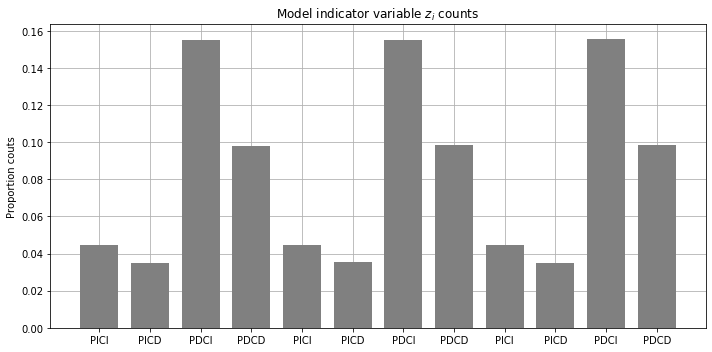

In [4]:
# Show all subjects counts of z
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.hist(
    z.flatten(), 
    np.arange(3 * n_models + 1) + .5,
    rwidth=.75, 
    density=True,
    color='gray'
)
ax.set_xticks(np.arange(1, 3 * n_models + 1))
ax.set_xticklabels(3 * modelnames)
ax.set_ylabel('Proportion couts')
ax.set_title('Model indicator variable $z_i$ counts')
ax.set_axisbelow(True)
ax.grid()

plt.tight_layout()
plt.show()

In [5]:
# Calculate posterior model probabilities
pmp = np.concatenate(
    tuple(np.sum((z == i) + (z == i+n_models) + (z == i+2*n_models), axis=(0, 1))[np.newaxis, :] 
          for i in range(1, 5)), 
    axis=0)

# Calculate model frequencies
freq = Counter(np.argmax(pmp, axis=0))
freq = {modelnames[k]: (v, v / n_subjects) for k, v in freq.items()}
print(freq)

# Save posterior model probabilities to *.mat format
pmp = pmp.astype(float)
pmp[pmp == 0] = np.finfo(float).eps 
scipy.io.savemat(
    file_name=os.path.join(path_vba, 'pmp_HLM_sequential_split.mat'), 
    mdict={'pmp': pmp}, 
    appendmat=True
)

{'PICI': (4, 0.125), 'PDCD': (8, 0.25), 'PDCI': (19, 0.59375), 'PICD': (1, 0.03125)}


### Posterior model probability plot

Plot posterior model probabilities for each subject and model based on the model indicator variable representing each variant of RL model.

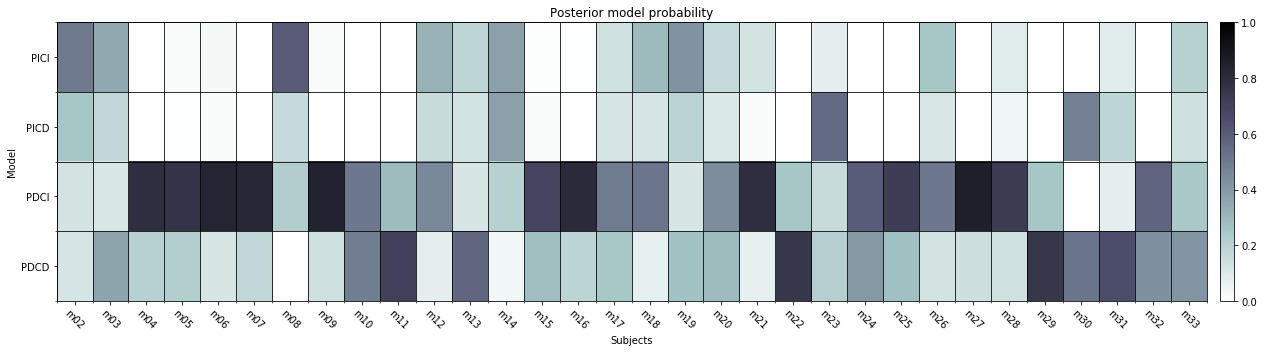

In [6]:
gen_pmp_implot(pmp, modelnames)

### Bayes factor for model families

Determine whether subject response patterns are better explained by models with:
- prediction error dependent (PD) vs. prediction error independent (PI) learning rates
- condition dependent (CD) vs. condition independent (CI) learning rates

Posterior model probabilities are first marginalized over subjects and then by model groups. Bayes factors are computed according to:
$$BF_{PD-PI}=\frac{p(D|M_{PDCI}\cup M_{PDCD})}{p(D|M_{PICI}\cup M_{PICD})}$$
$$BF_{CD-CI}=\frac{p(D|M_{PICD}\cup M_{PDCD})}{p(D|M_{PICI}\cup M_{PDCI})}$$

In [7]:
pmp_marg = np.sum(pmp, axis=1)

bf_pd_pi = ((pmp_marg[modelnames.index('PDCI')] + pmp_marg[modelnames.index('PDCD')]) / 
            (pmp_marg[modelnames.index('PICI')] + pmp_marg[modelnames.index('PICD')])) 
bf_cd_ci = ((pmp_marg[modelnames.index('PICD')] + pmp_marg[modelnames.index('PDCD')]) / 
            (pmp_marg[modelnames.index('PICI')] + pmp_marg[modelnames.index('PDCI')])) 

print(f'BF(PD - PI) = {bf_pd_pi}')
print(f'BF(CD - CI) = {bf_cd_ci}')

BF(PD - PI) = 3.191791947393011
BF(CD - CI) = 0.6670733052072597


### Posterior exceedance probability on model frequency

Before running code below run `dn_bm_03_vba.m` script to obtain posterior exceedance probabilities

pep(PICI) = 8.063734704582753e-05
pep(PICD) = 8.063734704582753e-05
pep(PDCI) = 0.9995281621452218
pep(PDCD) = 0.00031056316068654537



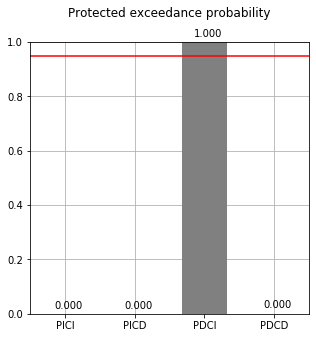

In [8]:
mat = scipy.io.loadmat(os.path.join(path_vba, 'pep_HLM_sequential_split.mat'), squeeze_me=True)

print(f'pep(PICI) = {mat["pep"][modelnames.index("PICI")]}')
print(f'pep(PICD) = {mat["pep"][modelnames.index("PICD")]}')
print(f'pep(PDCI) = {mat["pep"][modelnames.index("PDCI")]}')
print(f'pep(PDCD) = {mat["pep"][modelnames.index("PDCD")]}\n')

gen_pep_barplot(mat['pep'], modelnames)